In [1]:
import os
import pandas as pd
import numpy as np
import math
import re
from collections import defaultdict
from utils import *

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import words, PlaintextCorpusReader
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
parent_path = '/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis'

os.environ.update({'MALLET_HOME':r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8'})
mallet_path = r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8/bin/mallet' 

In [4]:
social_media_data_folder_paths = [
    f'{parent_path}/Data/Hardwarezone Data/Cleaned Data', 
    f'{parent_path}/Data/Twitter Data/Cleaned Data/Policies/Combined',
    f'{parent_path}/Data/Facebook Data/Cleaned Data/Policies/Combined',
    f'{parent_path}/Data/Instagram Data/Cleaned Data/Policies/Combined',
    f'{parent_path}/Data/Reddit Data/Cleaned Data/Policies/Combined',
]

In [5]:
stop_list = nltk.corpus.stopwords.words('english')

In [7]:
df = get_policy_data('foreign worker', social_media_data_folder_paths)

True
True
True
True
True


In [8]:
valuable_comments = get_valuable_comments(df)
actionable_comments = get_actionable_comments(df)

In [9]:
print(len(valuable_comments))
print(len(actionable_comments))
print(len(df))

2048
672
12307


In [10]:
stop_list = nltk.corpus.stopwords.words('english')
# stop_list += ['singapore', 'shn', 'people', 'cases', 'covid', 'case', 'thing', 'things']

# pos_tags = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']
# 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
def corpus2docs_1(df):
    docs1 = [TweetTokenizer().tokenize(comment) for comment in df['Comments']]
    # for i, comment in enumerate(docs1):
    #     tags = nltk.pos_tag(comment)
    #     docs_tags = [tag[0].lower() for tag in tags if tag[1] in pos_tags]
    #     docs1[i] = docs_tags
    docs1_1 = [[w.lower() for w in doc] for doc in docs1]
    docs2 = [[w for w in doc if len(w) > 2] for doc in docs1_1]
    docs3 = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs2]
    docs4 = [[w for w in doc if w not in stop_list] for doc in docs3]
    return docs4

In [11]:
valuable_docs = corpus2docs_1(valuable_comments)
valuable_dic = gensim.corpora.Dictionary(valuable_docs)
valuable_vecs = docs2vecs(valuable_docs, valuable_dic)

In [12]:
lda_shn = topics_visualization_gensim(valuable_vecs, valuable_dic, 3, 'foreign worker_valuable', 20)

# LDA Mallet

In [13]:
def get_policy_data(policy, folders):
    frames = []
    for folder in folders:
        files = [file for file in os.listdir(folder) if file.endswith('.csv')]
        for file in files:
            if policy.lower() in file.lower():
                df = pd.read_csv(f'{folder}/{file}')
                df = df[['Comments', 'Comment Datetime', 'actionable', 'valuable']]
                frames.append(df)
                break
    final_df = pd.concat(frames, ignore_index=True)
    return final_df

def corpus2docs(df):
    docs1 = [TweetTokenizer().tokenize(comment) for comment in df['Comments']]
    docs2 = [[w.lower() for w in doc] for doc in docs1]
    docs3 = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs2]
    docs4 = [[w for w in doc if w not in stop_list] for doc in docs3]
    return docs4

def docs2vecs(docs, dic):
    vecs = [dic.doc2bow(doc) for doc in docs]
    return vecs

def topics_visualization_gensim(vecs, dic, num_topics, topic, top_words):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=vecs, id2word=dic, num_topics=num_topics)
    pyLDAvis.enable_notebook()
    visual= pyLDAvis.gensim.prepare(lda_model, vecs, dic)
    pyLDAvis.save_html(visual, f"{topic}_viz_gensim.html")
    return lda_model.show_topics(num_topics, top_words)

In [16]:
os.environ.update({'MALLET_HOME':r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8'})
mallet_path = r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8/bin/mallet' #update this path

no_topics= 5#make this 2 to test. 
no_iter=500 #make this 50 to test

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=valuable_vecs, iterations=no_iter, num_topics=no_topics, id2word=valuable_dic, random_seed=99, alpha=0.1)

In [17]:
vecTop = ldamallet.show_topics(num_words=30)
for i in range(0, 5):
    print(vecTop[i])
    print()

(0, '0.014*"people" + 0.013*"home" + 0.012*"work" + 0.010*"workers" + 0.008*"stay" + 0.008*"time" + 0.007*"care" + 0.007*"government" + 0.007*"good" + 0.006*"singapore" + 0.006*"back" + 0.005*"food" + 0.005*"mom" + 0.005*"mask" + 0.005*"family" + 0.005*"virus" + 0.005*"make" + 0.004*"safe" + 0.004*"lee" + 0.004*"sir" + 0.004*"day" + 0.004*"essential" + 0.004*"measures" + 0.004*"hope" + 0.004*"employers" + 0.003*"country" + 0.003*"social" + 0.003*"distancing" + 0.003*"life" + 0.003*"foreign"')

(1, '0.010*"world" + 0.009*"government" + 0.007*"people" + 0.007*"mom" + 0.006*"loans" + 0.006*"dorm" + 0.006*"problem" + 0.005*"loan" + 0.005*"back" + 0.005*"things" + 0.005*"time" + 0.005*"companies" + 0.005*"build" + 0.005*"bad" + 0.005*"singapore" + 0.005*"business" + 0.005*"market" + 0.005*"point" + 0.004*"made" + 0.004*"law" + 0.004*"money" + 0.004*"owners" + 0.004*"act" + 0.004*"countries" + 0.004*"specifically" + 0.004*"freedom" + 0.004*"give" + 0.004*"company" + 0.003*"cost" + 0.003*"wor

# Coherence Score

In [14]:
model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 20):
    # lda_gensim = gensim.models.ldamodel.LdaModel(corpus=valuable_vecs, id2word=valuable_dic, num_topics=num_topics, random_state=99, iterations=100)
    lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, iterations=500, corpus=valuable_vecs, num_topics=num_topics, id2word=valuable_dic, random_seed=99)
    coherencemodel = CoherenceModel(model=lda_mallet, texts=valuable_docs, dictionary=valuable_dic, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_mallet)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

#Topics: 2 Score: 0.30971307790454794
#Topics: 3 Score: 0.31218721241157565
#Topics: 4 Score: 0.33920642625590186
#Topics: 5 Score: 0.3761770226925374
#Topics: 6 Score: 0.25721855711732067
#Topics: 7 Score: 0.3402690448210817
#Topics: 8 Score: 0.3676239475883365
#Topics: 9 Score: 0.3665175125073101
#Topics: 10 Score: 0.36994351102203343
#Topics: 11 Score: 0.3340277419879915
#Topics: 12 Score: 0.3817125798971038
#Topics: 13 Score: 0.35689537528451887
#Topics: 14 Score: 0.3838786522966998
#Topics: 15 Score: 0.38395507017714475
#Topics: 16 Score: 0.3290049703417087
#Topics: 17 Score: 0.34447819550875963
#Topics: 18 Score: 0.36751980937452844
#Topics: 19 Score: 0.36614990854869645


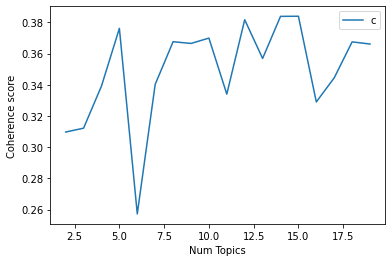

In [19]:
import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
def create_pyLDAvis(lda_mallet, vecs, dic, filename):
    mallet_lda_model= gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

    pyLDAvis.enable_notebook()
    visual= pyLDAvis.gensim.prepare(mallet_lda_model, vecs, dic)
    pyLDAvis.save_html(visual, f"{filename}_viz.html")

create_pyLDAvis(ldamallet, valuable_vecs, valuable_dic, 'foreign_worker')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


# Dominant topic for each document

In [23]:
def format_topics_sentences(ldamodel, corpus, data, ori_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    ori_text = ori_data['Comments']
    sent_topics_df = pd.concat([sent_topics_df, contents, ori_text], axis=1)
    df_dominant_topic = sent_topics_df.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tokenized Text', 'Comments']

    return df_dominant_topic

#df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[1], corpus=sg_vecs, data=sg_docs)
valuable_comments.reset_index(inplace=True)
df_dominant_topic = format_topics_sentences(ldamodel=ldamallet, corpus=valuable_vecs, data=valuable_docs, ori_data=valuable_comments)

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tokenized Text,Comments
0,0,2.0,0.8074,"cases, workers, covid, testing, singapore, peo...","[cases, residing, dormitories, case, residing,...",Cases residing in dormitories: 1 There is 1 ca...
1,1,3.0,0.5031,"workers, living, foreign, conditions, dorms, p...","[almost, dorm, world, like, stayed, oversea, d...",Almost all dorm in the world is like that. I s...
2,2,3.0,0.7397,"workers, living, foreign, conditions, dorms, p...","[clon, wrote, mom, never, jail, dormitory, ope...",clon33 wrote: Why MOM never jail these dormito...
3,3,1.0,0.4429,"world, government, people, mom, loans, dorm, p...","[dorm, operators, punished, violating, regulat...",0 dorm operators were punished for violating r...
4,4,3.0,0.5925,"workers, living, foreign, conditions, dorms, p...","[wrote, abalone, zhup, dormitory, starting, ig...",Food_Lover wrote: Abalone Zhup: https://www.fa...


In [31]:
topic_1 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1.0]
sample = topic_1['Comments'].sample(n=10, random_state=10)
for i in sample:
    print(i + '\n')    

What you have built has made many dreams come true, visible in the video I have stitched together for me, people the world over, and now you to admire. Hope the music and visual journey keeps you entertained and inspires you as much as you have inspired me into making the video that has gained 25,000 views from around the world. Thank you! https://youtu.be/RpT7SrxUYns

If you think this was written just to show how bad Trump’s administration was then you’re vastly overstating how much effort needed to go into showing how bad his administration was. It didn’t take a scientific paper to see it, you just need to have eyes or ears and a brain that’s functioning above the level of your average newborn house cat.

I think some basic rights should be guaranteed around their safety and health.

Maggio Capital is one of the legitimate proven and trusted hard money lending private company we have available today in the world today when it comes to online lending companies, We are specialist in e

In [28]:
for i in range(5):
    print(df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i]['Keywords'].iloc[0])
    print()


people, home, work, workers, stay, time, care, good, government, singapore

world, government, people, mom, loans, dorm, problem, loan, back, time

cases, workers, covid, testing, singapore, people, migrant, dormitories, numbers, community

workers, living, foreign, conditions, dorms, people, dorm, companies, singapore, pay

government, workers, conditions, singapore, back, people, point, dorms, foreign, construction



In [14]:
df_dominant_topic.to_csv('/Users/chenjianyu/Desktop/shn_dominant_topic.csv', index=False)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Most representative sentence for each topic

In [40]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9175,"singapore, covid, virus, government, cases, measures, safe, workers, social, circuit","[country, public, health, advisory, nation, immune, health, healthy, sports, recreational, activ..."
1,1.0,0.8129,"people, home, time, good, mask, essential, work, family, risk, lee","[god, church, members, christian, home, motions, christian, things, christian, god, purpose, mea..."


In [41]:
sent_topics_sorteddf_mallet['Representative Text'].iloc[0]

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['country',
 'public',
 'health',
 'advisory',
 'nation',
 'immune',
 'health',
 'healthy',
 'sports',
 'recreational',
 'activities',
 'outdoor',
 'activities',
 'plenty',
 'natural',
 'sunlight',
 'vitamin',
 'special',
 'attention',
 'vulnerable',
 'group',
 'fake',
 'science',
 'lockdown',
 'model',
 'strong',
 'pandemic',
 'respiratory',
 'outbreak',
 'real',
 'epidemiological',
 'science',
 'model',
 'healthy',
 'individuals',
 'immunity',
 'virus',
 'healthy',
 'individuals',
 'little',
 'flu',
 'symptoms',
 'respiratory',
 'illness',
 'fauci',
 'wittkowski',
 'endless',
 'mitigations',
 'herd',
 'immunity',
 'public',
 'health',
 'advisory',
 'whole',
 'nation',
 'home',
 'fear',
 'msm',
 'repeated',
 'media',
 'broadcasts',
 'whole',
 'nation',
 'stress',
 'immune',
 'system',
 'point',
 'scientific',
 'evidence',
 'pcr',
 'test',
 'machine',
 'gold',
 'standard',
 'test',
 'virus',
 'unauthorised',
 'human',
 'dna',
 'harvesting',
 'kary',
 'mullis',
 'phd',
 'biochemist',
 '

# Frequency Distribution of words counts in documents

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


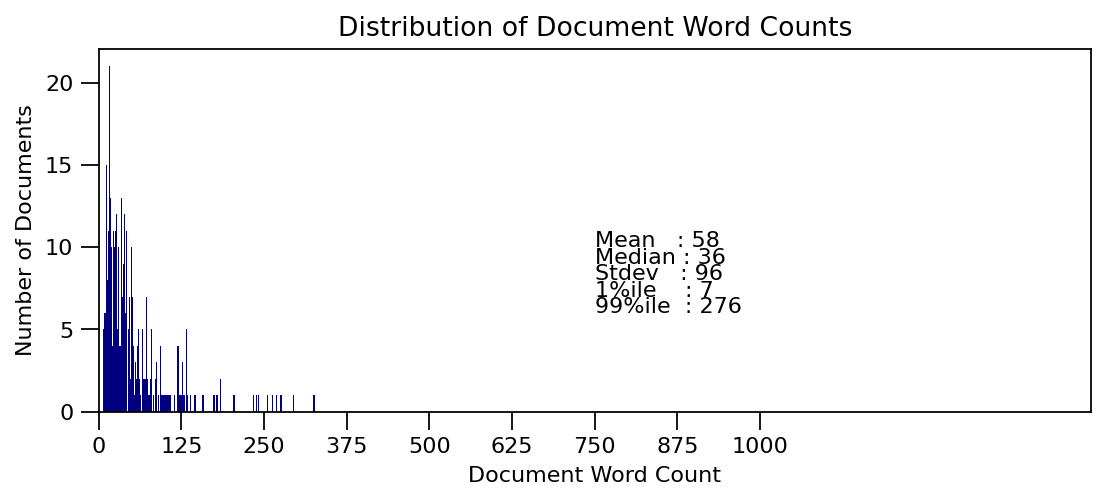

In [72]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,3), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 10, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  9, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  8, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  7, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  6, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=8)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

# Actionable Comments

In [11]:
actionable_docs = corpus2docs_1(actionable_comments)
actionable_dic = gensim.corpora.Dictionary(actionable_docs)
actionable_vecs = docs2vecs(actionable_docs, actionable_dic)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 10):
    # lda_gensim = gensim.models.ldamodel.LdaModel(corpus=valuable_vecs, id2word=valuable_dic, num_topics=num_topics, random_state=99, iterations=100)
    lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, iterations=500, corpus=actionable_vecs, num_topics=num_topics, id2word=actionable_dic, random_seed=99)
    coherencemodel = CoherenceModel(model=lda_mallet, texts=actionable_docs, dictionary=actionable_dic, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_mallet)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
#Topics: 2 Score: 0.3597503198981696
#Topics: 3 Score: 0.43048108427532866
#Topics: 4 Score: 0.4054769400360012
#Topics: 5 Score: 0.46339609915120794
#Topics: 6 Score: 0.4289789448001884
#Topics: 7 Score: 0.4186791088060459
#Topics: 8 Score: 0.4430595461617407
#Topics: 9 Score: 0.4180399124966778


/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


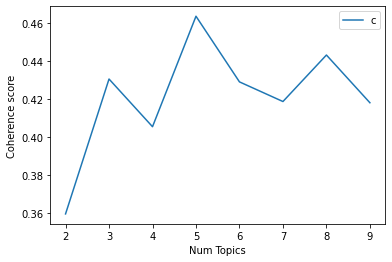

In [14]:
import matplotlib.pyplot as plt

limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=actionable_vecs, iterations=500, num_topics=5, id2word=actionable_dic, random_seed=99, alpha=0.1)
mallet_lda_model= gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
pyLDAvis.enable_notebook()
visual= pyLDAvis.gensim.prepare(mallet_lda_model, actionable_vecs, actionable_dic)
pyLDAvis.save_html(visual, f"./pyLDAvis/cb_actionable_viz.html")

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_t

In [22]:
act_df = pd.read_csv(f'{parent_path}/Data/Sentiment Data/circuit breaker_actionable_sentiments.csv')
act_df['Topic'] = 'Circuit Breaker'

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
def remove_hashtag_mentions_urls(text):
    # e.sub(r"(?:\@|https?\://)\S+", "", text) # remove mentions and url only
    return re.sub(r"(?:\@|\#|https?\://)\S+", "", text)


noun_tags = ['NN', 'NNS', 'NNP', 'NNPS'] # POS tags for nouns

def topic_doc_unigram(doc_words: list, k: int = 1) -> (defaultdict, list):
    """
    Creating unigram model for all the nouns in the policy topic text document.  

    Args:
        doc_words (list): list of tokenized words in the text document
        k (int): smoothing pseudo-count for each unigram

    Returns:
        [defaultdict]: unigram model with every unigram as key and its probabilty as value
        [list]: list of nouns in the document
    """
    doc_tags = nltk.pos_tag(doc_words)
    doc_nouns_tag = [tag[0].lower() for tag in doc_tags if tag[1] in noun_tags]
    doc_nouns = [w for w in doc_nouns_tag if re.search('^[a-z]+$', w)]

    num_words = len(doc_nouns)

    nouns_count = defaultdict(int)
    for word in doc_nouns:
        nouns_count[word] += 1
    nouns_count['[UNK]'] = 0
    
    vocab_size = len(nouns_count)

    doc_unigram = defaultdict(int)
    for key, v in nouns_count.items():
        doc_unigram[key] = (v + k) / (num_words + k*vocab_size)
    
    return doc_unigram, doc_nouns


def comment_unigram(comment: str, k: int = 1) -> (defaultdict, list):
    """
    Creating unigram model for all the nouns in an user's comment.

    Args:
        doc_words (list): list of tokenized words in the comment
        k (int): smoothing pseudo-count for each unigram

    Returns:
        [defaultdict]: unigram model with every unigram as key and its probabilty as value
        [list]: list of nouns in the comment
    """
    comment_words = word_tokenize(comment)
    comment_tags = nltk.pos_tag(comment_words)
    comment_nouns_tag = [tag[0].lower() for tag in comment_tags if tag[1] in noun_tags]
    comment_nouns = [w for w in comment_nouns_tag if re.search('^[a-z]+$', w)]

    num_words = len(comment_nouns)

    cmt_nouns_count = defaultdict(int)
    for word in comment_nouns:
        cmt_nouns_count[word] += 1
    cmt_nouns_count['[UNK]'] = 0
    
    vocab_size = len(cmt_nouns_count)

    cmt_unigram = defaultdict(int)
    for key, v in cmt_nouns_count.items():
        cmt_unigram[key] = (v + k) / (num_words + k*vocab_size)
    
    return cmt_unigram, comment_nouns

def KLDiv_relevance_score(doc_unigram: dict, comment_unigram: dict, doc_nouns: list, comment_nouns: list) -> int:
    """
    Calculate the KL-divergence relevance score between targetted document unigram model and comment unigram model. Feature 5 for thoughtful model (Relevance feature). 

    Args:
        doc_unigram (dict): Targetted document unigram model with nouns only
        comment_unigram (dict): Comment unigram model with nouns only
        doc_nouns (list): list of nouns in targetted document
        comment_nouns (list): list of nouns in comment

    Returns:
        int: KL-divergence relevance score
    """
    total_vocab = set(doc_nouns).union(set(comment_nouns))

    kl_div = 0
    for word in total_vocab:
        # if comment_unigram[word] * doc_unigram[word] != 0:
        if word not in doc_unigram:
            kl_div += comment_unigram[word] * math.log(comment_unigram[word] / doc_unigram['[UNK]'])
        elif word not in comment_unigram:
            kl_div += comment_unigram['[UNK]'] * math.log(comment_unigram['[UNK]'] / doc_unigram[word])
        else:
            kl_div += comment_unigram[word] * math.log(comment_unigram[word] / doc_unigram[word])

    # if kl_div > 0:
    #     return kl_div
    # else: 
    #     return 7.5 
    return kl_div

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
circuit_breaker_comments = act_df[act_df['Topic'] == 'Circuit Breaker']
# economic_measures_comments = cb_df[cb_df['Topic'] == 'Economic Measures']
# foreign_worker_comments = cb_df[cb_df['Topic'] == 'Foreign Worker']
# mask_comments = cb_df[cb_df['Topic'] == 'Mask']
# phases_comments = cb_df[cb_df['Topic'] == 'Phases']
# safe_entry_comments = cb_df[cb_df['Topic'] == 'Safe Entry']
# social_distancing_comments = cb_df[cb_df['Topic'] == 'Social Distancing']
# stay_home_notice_comments = cb_df[cb_df['Topic'] == 'Stay Home Notice']
# tracetogether_comments = em_df[em_df['Topic'] == 'Tracetogether']
# vaccination_comments = cb_df[cb_df['Topic'] == 'Vaccination']
comments = [circuit_breaker_comments]
# comments = [circuit_breaker_comments, economic_measures_comments ,foreign_worker_comments, mask_comments, phases_comments, safe_entry_comments, social_distancing_comments, stay_home_notice_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(len(comments)):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in act_df['Sentences']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

df_final['Relevance score'].describe()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
<ipython-input-30-3fb27198ddce>:1: DeprecationWarning: invalid escape sequence \.
  corpus = PlaintextCorpusReader('/Users/chenjianyu/Library/Mobile Documents/com~apple~CloudDocs/SMU/SMU Module Materials/Y2S2/SMT203 Computational Social Sci/Covid-19-Singapore-Analysis/Data/Policy Documents', '.+\.txt', encoding='utf-8')


count    3805.000000
mean       63.730872
std        93.341209
min         1.526433
25%        20.042259
50%        36.262030
75%        56.271756
max       408.447008
Name: Relevance score, dtype: float64

In [31]:
act_df = df_final[df_final['Relevance score'] <= 20]

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
anger = act_df[act_df['Emotions'] == 'anger']
anger.sort_values(by=['Vader_compound_score'], ascending=True)
anger['Sentences'].tolist()[0:5]

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['For electricity, use lesser aircon should be ok. My bills from WFH slightly higher than before WFH.',
 "For me, I'm lucky the company already are using virtual calls with overseas customers and HQ so in a way we already have the hardware and software for virtual conferences.",
 'Personally, if everyone can keep to office work at office hour, wfh should be quite enjoyable.',
 'He voluntarily refunded the amount he had used from his Ordinary Account for his share of the down payment on his Housing Board flat, and transferred money from his Ordinary Account, which has a base interest rate of 2.5 per cent per year, to his Special Account, which has a base interest rate of 4 per cent per year.',
 'He had started moving cash to his Special Account from 2018, after reading a CPF Board annual report where a chart showed that many people in his age group had more in CPF savings than he did.']

In [33]:
eng_words = words.words()
comments = []
i = 0
for row in act_df['Sentences']:
    text = remove_hashtag_mentions_urls(row)
    text_tokenize = TweetTokenizer().tokenize(text)
    text_lower = [w.lower() for w in text_tokenize]
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
    text_eng_words = [w for w in text_words_only if w in eng_words]
    text_drop_2letters = [w for w in text_eng_words if len(w) > 2]
    text_joined = ' '.join(text_drop_2letters)
    comments.append(text_joined)
    # print(i)
    i+=1

act_df['Comments'] = comments

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-33-f198fc54de9e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_df['Comments'] = comments


In [39]:
actionable_comments = pd.DataFrame(act_df['Comments'])
actionable_docs = corpus2docs_1(actionable_comments)
actionable_dic = gensim.corpora.Dictionary(actionable_docs)
actionable_vecs = docs2vecs(actionable_docs, actionable_dic)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 10):
    # lda_gensim = gensim.models.ldamodel.LdaModel(corpus=valuable_vecs, id2word=valuable_dic, num_topics=num_topics, random_state=99, iterations=100)
    lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, iterations=500, corpus=actionable_vecs, num_topics=num_topics, id2word=actionable_dic, random_seed=99)
    coherencemodel = CoherenceModel(model=lda_mallet, texts=actionable_docs, dictionary=actionable_dic, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_mallet)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
#Topics: 2 Score: 0.4049984835095968
#Topics: 3 Score: 0.4634319123886463
#Topics: 4 Score: 0.5169525047585871
#Topics: 5 Score: 0.5330131764572389
#Topics: 6 Score: 0.56572189093451
#Topics: 7 Score: 0.5519994025927359
#Topics: 8 Score: 0.5771964548898234
#Topics: 9 Score: 0.5942885951564424


/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


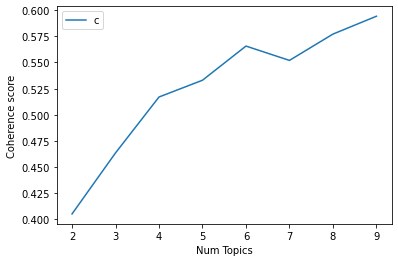

In [45]:
import matplotlib.pyplot as plt

limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=actionable_vecs, iterations=500, num_topics=6, id2word=actionable_dic, random_seed=99, alpha=0.1)
mallet_lda_model= gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
pyLDAvis.enable_notebook()
visual= pyLDAvis.gensim.prepare(mallet_lda_model, actionable_vecs, actionable_dic)
pyLDAvis.save_html(visual, f"./pyLDAvis/cb_actionable_viz.html")

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_t